### <a class="anchor" id="1.5_bullet" style="color:#B05883"> **Importing libraries** </a>



In [1]:
from collections import defaultdict
from faker import Faker
import pandas as pd
import numpy as np
import datetime
#from datetime import datetime, timedelta
import hashlib
import random
import math
import os
import bisect
from typing import Optional, Union, Any, Dict, List, TypeVar, Tuple


import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from hops import hdfs
#from hops import pandas_helper as pandas
#from faker.providers.address.sv_SE import Provider as SvSEProvider

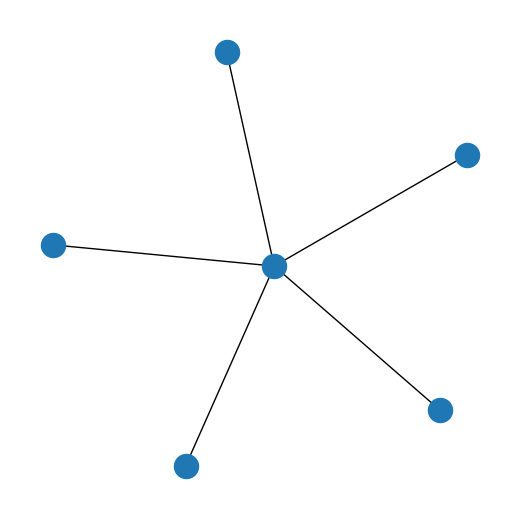

In [2]:
plt.figure(figsize=(5,5))
#e.head()
G = nx.star_graph(5)
pos=nx.spring_layout(G)
# print(nx.to_pandas_edgelist(G))
nx.draw(G,pos)
plt.show()
# make_df_from_graph(G, card_numbers)

In [3]:
faker = Faker()
faker.seed_locale('en_US', 0)

# Seed for Reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
faker.seed_instance(SEED)

In [4]:
def generate_card_numbers(number_of_cards: int, providers=["visa", "mastercard"]):
    """
        Randomly generate specififc number of credit cards.
    
        Parameters
        ----------
        number_of_cards : int,
            Integer that represents number of generated card numbers.
        providers : list, default ["visa", "mastercard"]
            List of credit card providers.
    
        Returns
        -------
        list
            List of generated card numbers.
    """
    
    card_numbers = set()
    for _ in range(number_of_cards):
        provider = random.choice(providers)
        card_number = faker.credit_card_number(card_type=provider)
        card_numbers.add(card_number)
    return list(card_numbers)  

In [5]:
def get_random_transaction_amount(start: float, end: float) -> float:
    """
        Return a sample from a uniform distribution from given boundaries.
        
        Parameters
        ----------
        start : float
            Left boundary.
        end : float
            Right boundary.
            
        Returns
        -------
        float
            Rounded random float number considered as amount of transaction. 
        
    """
    amt = round(np.random.uniform(start, end), 2)
    return amt

In [6]:
def generate_transaction_id(source: str, target: str, timestamp: str, amount: float) -> str:
    """
        Generates transaction ID using MD5 hash function using basic features like source, target, timestamp and amount of specific transaction.
        This transaction ID will be used as index.
        
        Parameters
        ----------
        source : str
            Source card number, sender.
        target : str
            Target card number, reciever.
        timestamp: str
            Timestamp of transaction.
        amount : float
            Amount of transaction.
            
        Returns
        -------
        str
            Generated hash.
            
    """
    hashable = f'{timestamp}{source}{target}{amount}'
    hexdigest = hashlib.md5(hashable.encode('utf-8')).hexdigest()
    return hexdigest

In [7]:
def make_df_from_graph(G, corporate_card_numbers: list, private_card_numbers: list,
                       start_date, end_date, date_format='%Y-%m-%d %H:%M:%S',
                       drop_time=True, amount_distribution=None, surely_no_central_node=False):
    """
        Make a pandas DataFrame of synthetic card transactions that follows specific graph pattern and a DataFrame with profile mappings.
        
        Parameters
        ----------
        G : function from networkx.generators.classic package
            Udefined function for graph creation from networkx.generators.classic package.
        corporate_card_numbers : list,
            List of card numbers that are considered as corporate ones. ["5230424272238224", ...]
        private_card_numbers : list,
            List of card numbers that are considered as private ones. ["2294908344985028", ...]
        start_date: datetime.date
            Minimum datetime for generated transactions.
        end_date : datetime.date
            Maximum datetime for generated transactions.
        date_format : str
            Datetime format in which start_date and end_date are passed
        drop_time : bool, default True
            If True, drops start_date and end_date time to 00:00:00. 
        amount_distribution : dict, default None
            A dictionary of percentages and corresponding tuple-like boundaries for random amount selection.
            In other words, it is a distribution for amount values.
        surely_no_central_node: bool, default False
            If True, the algorithm does not checks for the possible central node in graph (skips this step).
        
        Returns
        -------
        iterable
            Iterable of two pandas DataFrames.
            First one contains generated transactions with ['source', 'target', 'timestamp', 'amount'] columns.
            Second one contains profile mappings - ['card_id', 'party'] columns.
        
    """
    
    if not amount_distribution:
        amount_distribution = {
                                   0.05: (0.01, 1.01), 
                                   0.075: (1, 11.01),
                                   0.525: (10, 100.01),
                                   0.25: (100, 1000.01),
                                   0.099: (1000, 10000.01),
                                   0.001: (10000, 30000.01)
                                  }
        
    df_from_graph = nx.to_pandas_edgelist(G)

    profiles_df_batch = pd.DataFrame({"card_id": df_from_graph["source"].append(df_from_graph["target"]).unique(),
                                      "party": "private"})
    
    # amounts
    TOTAL_UNIQUE_TRANSACTIONS = df_from_graph.shape[0]
    amounts = []
    
    z = 1000

    for percentage, span in amount_distribution.items():
            n = int(z * percentage)
            start, end = span
            for _ in range(n):
                amounts.append(get_random_transaction_amount(start, end+1))

    amounts = random.sample(amounts, TOTAL_UNIQUE_TRANSACTIONS)
    
    # timestamps
    if drop_time:
        start_date = str(start_date) + " 00:00:00"
        end_date = str(end_date) + " 00:00:00"
        start_date = datetime.datetime.strptime(start_date, date_format)
        end_date = datetime.datetime.strptime(end_date, date_format)
    
    timestamps = list()
    for _ in range(TOTAL_UNIQUE_TRANSACTIONS):
            timestamp = faker.date_time_between(start_date=start_date, end_date=end_date, tzinfo=None)\
                             .strftime(date_format)
            timestamps.append(timestamp)
    timestamps = sorted(timestamps)
    

    # mapping everything
    try:
        for i in ["source", "target"]:
                df_from_graph[i] = df_from_graph[i].apply(lambda x: private_card_numbers[x])
        profiles_df_batch["card_id"] = profiles_df_batch["card_id"].apply(lambda y: private_card_numbers[y])
    except IndexError:
        print("ERROR! The number of unique card ids is lower then number of nodes in this graph! I return (None, None).")
        return None, None
    
    # central node check (if we say there might be a central node)
    if not surely_no_central_node:
        ## if number of specific card >= 1/2 of number of rows in the graph_from_df, this card id called a centroid and corporate number
        if df_from_graph['source'].value_counts().reset_index()["source"][0] >=  df_from_graph.shape[0] / 2:
            central_node = df_from_graph['source'].value_counts().reset_index()["index"][0]
            corporate_card_number = random.choice(corporate_card_numbers)
            
            # the central node always only in 'source' column, and never in 'target'.
            df_from_graph.loc[df_from_graph["source"] == central_node, 'source'] = corporate_card_number
            profiles_df_batch.loc[profiles_df_batch["card_id"] == central_node, 'party'] = "corporate"
            profiles_df_batch.loc[profiles_df_batch["card_id"] == central_node, 'card_id'] = corporate_card_number
            
        
    # adding 'timestamp' and 'amount'
    df_from_graph["timestamp"] = timestamps
    df_from_graph["amount"] = amounts
    
    # hashes as indexes
    df_from_graph.index = df_from_graph.apply(lambda x: generate_transaction_id(*x), axis=1)
    
    
    return df_from_graph, profiles_df_batch

In [8]:
private_card_numbers=generate_card_numbers(100)
corporate_card_numbers=generate_card_numbers(1)

In [11]:
# show only 'transactions' df ('make_df_from_graph' returns a tuple)
df0, profiles0 = make_df_from_graph(G, corporate_card_numbers, private_card_numbers, datetime.date(2022, 6, 1), datetime.date(2022, 7, 1))

In [12]:
df0

,source,target,timestamp,amount
afbf5418a69e4fc9092aa37bf5f1afa1,2262337511737632,5230424272238224,2022-06-16 00:33:57,1.27
b0f030ecc05aabc6cbc9d65387fb987a,2262337511737632,2286249568603736,2022-06-16 15:33:24,71.97
42db06d27495af9c27c90335db2ce95d,2262337511737632,4657107090612129,2022-06-19 21:32:08,37.36
aa8f9b629c139d8383869ecf608111ac,2262337511737632,2294908344985028,2022-06-26 21:36:18,4641.26
5d4f62b15cf5af8db12ed855d8a905e2,2262337511737632,4596457231082508,2022-06-27 00:58:21,71.71


# ✅✅✅ TODO: 
____
## Code should iterate and randomly pick up graph patterns and append to pandas DF. Also in every pattern try to have it within one month  

In [15]:
def last_day_of_month(any_day):
    """
        Takes a day from any month and returns the last day of this month in datetime format.
        
        Parameters
        ----------
        any_day : datetime.date
            A day of any month. datetime.date format.
            
        Returns
        -------
        datetime.date
            The last day of that month.
    """
    
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - datetime.timedelta(days=next_month.day)

In [16]:
month = 5
    
start_date = datetime.date(2022, month, 1)
end_date = last_day_of_month(start_date)

In [17]:
def generate_transactions(iterations: int, corporate_card_numbers:list, private_card_numbers: list, nodes_num_range=[4, 8], month=5, verbose=False):
    
    """
        Generate a pandas DataFrame containing transactions, that are created using randomly selected graph patterns
        and a DataFrame with profile mappings.
        
        Parameters
        ----------
        iterations : int
            Number of random graph patterns to be converted to transactions dataframe.
        corporate_card_numbers : list,
            List of card numbers that are considered as corporate ones. ["5230424272238224", ...]
        private_card_numbers : list,
            List of card numbers that are considered as private ones. ["2294908344985028", ...]
        nodes_num_range: list
            A range to select number of nodes in each graph.
            If you choose big values, each dataframe will be correspondigly big. More transactions will be generated.
        month : int
            Month number in calendar. Starting with 1 (January).
            All generated transactions will be performed within what month .
        verbose : bool, default False
            If True, logs will be printing in console.
        
        Returns
        -------
        iterable
            Iterable of two pandas DataFrames.
            First one contains generated transactions with ['source', 'target', 'timestamp', 'amount'] columns.
            Second one contains profile mappings - ['card_id', 'party'] columns.

    """
    
    left, right = nodes_num_range
    
    start_date = datetime.date(2022, month, 1)
    end_date = last_day_of_month(start_date)
    
    
    one_arg_graph_set =[
        nx.binomial_tree,
        nx.complete_graph,
        nx.circular_ladder_graph,
        nx.cycle_graph,
        nx.path_graph,
        nx.star_graph,
        nx.wheel_graph,
        nx.dorogovtsev_goltsev_mendes_graph
    ]

    two_arg_graph_set = [
        nx.balanced_tree,
        nx.barbell_graph,
        nx.full_rary_tree,
        nx.lollipop_graph,
        nx.connected_caveman_graph,
        nx.turan_graph,
    ]

    graphs_with_central_node = [nx.star_graph,
                                nx.full_rary_tree,
                                nx.wheel_graph]
#     many_arg_graph_set = [
#         nx.complete_multipartite_graph

#     ]
    
    graph_sets = [one_arg_graph_set, two_arg_graph_set]
    
    res = pd.DataFrame()
    profiles = pd.DataFrame()
    
    for _ in range(iterations):
        choice = random.choice([1, 1, 2])
        args = np.random.randint(left, right, choice)
    

        graph_object = random.choice(graph_sets[choice - 1])
        
        surely_no_central_node= False
        if graph_object not in graphs_with_central_node:
            surely_no_central_node = True
        
        if graph_object == nx.balanced_tree:
            args[0] = np.random.randint(1, left)
        if graph_object == nx.turan_graph and args[0] < args[1]:
            args = np.flip(args)
        if graph_object == nx.dorogovtsev_goltsev_mendes_graph and args > 3:
            args = [np.random.randint(1, left - 1)] ############### Need to experimentally specify universal rule
                                                    ############# for arg in dorogovtsev_goltsev_mendes_graph
            
        if verbose:
            print(graph_object, "Args:", args)
        
        
        
        G = graph_object(*args)
        
        zock = 0
        while nx.to_pandas_edgelist(G).shape[0] > len(private_card_numbers) and zock < 3:
            args = args//2
            G = graph_object(*args)
            if verbose: print("Oops -", graph_object, " --> Args are being decreased by a factor of 2. New args:", args)
            zock += 1
        if zock == 3:
            continue
        
        df_batch, profiles_df_batch, = make_df_from_graph(G, corporate_card_numbers, private_card_numbers,
                                                          start_date, end_date,
                                                          surely_no_central_node=surely_no_central_node)

        res = res.append(df_batch)

        profiles = profiles.append(profiles_df_batch)
        
    res = res.sort_values(by=['timestamp'])
    
    return res, profiles.drop_duplicates().reset_index(drop=True)

In [18]:
private_card_numbers = generate_card_numbers(100)
corporate_card_numbers=generate_card_numbers(8)

In [19]:
# show only 'transactions' df ('generate_transactions' returns a tuple)
generate_transactions(2, corporate_card_numbers, private_card_numbers, nodes_num_range=[4, 5], month=5)[0]

,source,target,timestamp,amount
5ac931998d314c67afc00aa76a81f8a5,4071440707766063,5494736801722860,2022-05-12 15:19:19,58.13
f5f40f020bd3470ee3aad2bad304f704,4071440707766063,5164034625562228,2022-05-13 19:41:40,895.83
c23b0517dc265996cd633316e117b969,5424334848402889,5494736801722860,2022-05-13 20:38:40,47.28
d22b96ba55099f12d6d669d883b57a48,5424334848402889,5164034625562228,2022-05-17 05:25:40,9689.73
2d06fa1006eda192451a25358a2eae41,4071440707766063,2319486227681049,2022-05-20 11:46:50,76.98
6909fb2e597920198c7b78c090b21ca1,5424334848402889,2319486227681049,2022-05-23 14:41:45,353.67


# ✅✅✅ TODO 04.05.2022:
_____
## in normal case center node (which sends money, for example, to outer nodes) must be corporation/organization and transaction will occure once a month (lets say on 25th of May)  

##  'generate_transactions' have to return the df with all trans and the df with profile mappings. we pass list of private customers and list of corporate customers (card numbers)

In [ ]:

# plt.figure(figsize=(5,5))
# G = nx.connected_caveman_graph(3, 5)

# print(nx.to_pandas_edgelist(G).shape)
# print(nx.to_pandas_edgelist(G))
# pos=nx.spring_layout(G)
# nx.draw(G,pos)
# plt.show()


# ✅✅✅ TODO 10.05.2022:
____
## make a function that takes (private_card_numbers: list, corporate_card_numbers: list), arrange them in the way when every corporate number has a transactions to many private numbers (company pays salaries once a month), these private numbers do not intersect within different companies, returns a df of star graphs.

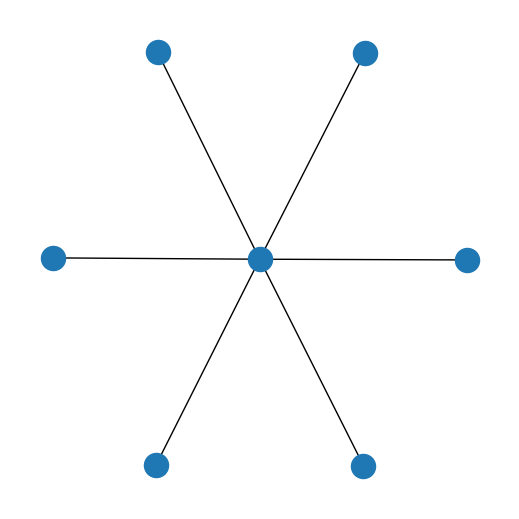

In [20]:
plt.figure(figsize=(5,5))
#e.head()
G = nx.star_graph(6)
pos=nx.spring_layout(G)
# print(nx.to_pandas_edgelist(G))
nx.draw(G,pos)
plt.show()
# make_df_from_graph(G, card_numbers)

In [21]:
def make_random_number_splits(number_of_splits: int, sum_of_numbers: int):
    """
        Generates a list of integers with length of number_of_splits. The sum of all elements equal to the sum_of_numbers argument.
        
        Parameters
        ----------
        number_of_splits : int
            Number of generated integers.
        sum_of_numbers : int,
            A number equal to the sum of all generated integers.
        
        Returns
        -------
        list
            A list of generated integers.
    """
    
    # Create an array of size 'number_of_splits' where every element is initialized to 0
    arr = [0] * number_of_splits;
     
    # To make the sum of the final list as sum_of_numbers
    for i in range(sum_of_numbers) :
 
        # Increment any random element
        # from the array by 1
        arr[random.randint(0, sum_of_numbers) % number_of_splits] += 1;
    
    return arr

In [22]:
def make_relationships(corporate_card_numbers: list, private_card_numbers: list):
    """
        Makes relationships one-to-many between 'corporate_card_numbers' and 'private_card_numbers'.
        One private number has a connection (transactions) only with one corporate one.
        
        Parameters
        ----------
        corporate_card_numbers : list,
            List of card numbers that are considered as corporate ones. ["5230424272238224", ...]
        private_card_numbers : list,
            List of card numbers that are considered as private ones. ["2294908344985028", ...]
        
        Returns
        -------
        dict
            Keys are corporate_card_numbers and the values are lists with private_card_numbers.
    """
    
    splits = make_random_number_splits(number_of_splits=len(corporate_card_numbers), sum_of_numbers=len(private_card_numbers))
    
    random.shuffle(private_card_numbers)
    
    
    relationships = dict()
    
    
    for corporate_card_number, split_index in zip(corporate_card_numbers, splits):
        relationships[corporate_card_number] = private_card_numbers[:split_index]
        private_card_numbers = private_card_numbers[split_index:]
    
    return relationships
    

In [23]:
def make_wage_transactions_df(corporate_card_numbers: list, private_card_numbers: list):
    """
        Generate a pandas DataFrame containing transactions, that are created using stargraph pattern
        and a DataFrame with profile mappings.
        It is an analogy for wage transactions. It means that resulting transactions dataframe has a stargraph structure
        and all transactions are committed on 25th of some month.
        
        Parameters
        ----------
        corporate_card_numbers : list,
            List of card numbers that are considered as corporate ones. ["5230424272238224", ...]
        private_card_numbers : list,
            List of card numbers that are considered as private ones. ["2294908344985028", ...]
        
        Notes
        -----
        Currently I have hardcoded the date - it is 25th of May (month=5).
        Also I have hardcoded the 'amount_distribution' - for the salary ranges.
        
        Returns
        -------
        iterable
            Iterable of two pandas DataFrames.
            First one contains generated transactions with ['source', 'target', 'timestamp', 'amount'] columns.
            Second one contains profile mappings - ['card_id', 'party'] columns.

    """
    
    # we will hardcode the date for now (remember that companies pay wages once a month)
    month = 5 # May
    day = 25
    date_format = '%Y-%m-%d %H:%M:%S'
    month_day = datetime.date(2022, month, day)

    start_date = str(month_day) + " 00:00:00"
    end_date = str(month_day) + " 23:59:59"
    start_date = datetime.datetime.strptime(start_date, date_format)
    end_date = datetime.datetime.strptime(end_date, date_format)
    
    # also we will hardcode the 'amount_distribution' for now
    
    amount_distribution = {        # key: tuple(float|int, float|int) means probability: (left, right)
                                   
                                   0.05: (12000, 26000), 
                                   0.275: (60000, 94000),
                                   0.325: (38000, 60000),
                                   0.25: (26000, 38000),
                                   0.099: (94000, 120000),
                                   0.001: (94000, 142000)
                                  }
    
    res = pd.DataFrame()
    profiles = pd.DataFrame()
    
    relationships = make_relationships(corporate_card_numbers, private_card_numbers)
    for corporate_card_number in relationships.keys():
        G = nx.star_graph(len(relationships[corporate_card_number]) - 1)
        df_batch, profiles_df_batch = make_df_from_graph(G, [corporate_card_number], relationships[corporate_card_number],
                                                         start_date, end_date,
                                                         drop_time=False,
                                                         amount_distribution=amount_distribution)

        res = res.append(df_batch)
        profiles = profiles.append(profiles_df_batch)
        
    res = res.sort_values(by=['timestamp'])
    return res, profiles.drop_duplicates().reset_index(drop=True)

In [ ]:
# corporate_card_numbers=generate_card_numbers(6)
# private_card_numbers=generate_card_numbers(100)

In [24]:
df2, profiles2 = make_wage_transactions_df(corporate_card_numbers, private_card_numbers)

In [25]:
profiles2

,card_id,party
0,4062860713016032,corporate
1,4812980371751150,private
2,5578670031206338,private
3,2237104856328027,private
4,2261390865604347,private
...,...,...
95,2622972989632355,private
96,4900084987407985,private
97,5237255558590190,private
98,2225642910484611,private


# TODO 11.05.2022:
____
## in function make_df_from_graph() and -> generate_transactions():
- ✅ refactor 'maybe_central_node' argument. This new argument should be for example 'surely_no_central_node'=False
- ✅ in generate_transactions() ... if graph not in [nx.star, ...] -> 'surely_no_central_node'=True and we skip check step
- ✅ if totally_no_central_node=True, of even after check we see that there is no central nodes, we should use not only private card numbers for mapping, but also a corporate ones. yes, they are not create a central-node-pattern, but corporate cards should also be able to make ordinary transaction.
- ✅ fix bug with 'card_id' in resulting 'profiles' df (look at next cell)

- ✅ add descriptions and additional comments to all functions